In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from skfuzzy import cluster
from itertools import combinations
from xgboost import XGBClassifier

import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import scipy
from scipy.spatial import distance

In [2]:
STOPWORDS = set(stopwords.words('english'))
PUNCT_TRANS = str.maketrans('', '', string.punctuation)

# Functions
## Dataset

In [4]:
def read_data(path=r'C:\Users\ADMIN\NCKH\Dataset'):
    features = ['ID', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'affiliation',
         'barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire', 'context']
    
    TRAIN = pd.concat([pd.read_csv(path+'/train.tsv', delimiter='\t', names=features, quoting=3),
                        pd.read_csv(path+'/valid.tsv', delimiter='\t', names=features, quoting=3)],
                        ignore_index=True)

    TEST = pd.read_csv(path+'/test.tsv', delimiter='\t', names=features, quoting=3)
    
    return TRAIN, TEST

## Preprocessing

In [6]:
def subtract_current_credit(row):
    
    label = row['label'] 
    try:
        row[label] -= 1  
    except:
        pass
    return row
    
def fill_na(data):

    text_features = ['statement', 'subject', 'speaker', 'job', 'state', 'affiliation', 'context']
    num_features = ['barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire']
    data[text_features] = data[text_features].fillna("unknown").astype(str)
    data[num_features] = data[num_features].fillna(0).astype(int)
    
    # subtract current_credit
    data = data.apply(subtract_current_credit, axis=1)
    return data

In [7]:
def TXT_preprocess(text):
    
    text = text.lower()
    text = text.translate(PUNCT_TRANS)
    text = ' '.join([word for word in word_tokenize(text) if word not in STOPWORDS])
    return text

def context_preprocess(text):
    
    text = text.lower()
    text = re.sub('e mail|e-mail|email|mailer','mail', text)
    text = re.sub('television','tv', text)
    text = re.sub('website','web', text)
    text = text.translate(PUNCT_TRANS)
    text = ' '.join([word for word in word_tokenize(text) if word not in STOPWORDS])
    return text
    
def subject_preprocess(text):

    text = text.lower()
    text = ' '.join(text.split(','))
    return text

def job_preprocess(text):

    text = text.lower()
    text = text.translate(PUNCT_TRANS)
    return text


In [8]:
class TXT_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['statement'].apply(TXT_preprocess)

class CT_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = pd.DataFrame()
        output['context'] = X['context'].apply(context_preprocess)
        output['subject'] = X['subject'].apply(subject_preprocess)
        output['job'] = X['job'].apply(job_preprocess)
        output['state'] = X['state'].str.lower()
        output['affiliation'] = X['affiliation'].str.lower()
        return output
        
class CT_Vectorizer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.context_vtr = TfidfVectorizer()
        self.subject_vtr = CountVectorizer(binary=True)
        self.job_vtr = CountVectorizer(binary=True)
        self.state_vtr = CountVectorizer(binary=True)
        self.affiliation_vtr = CountVectorizer(binary=True)
        
    def fit(self, X, y=None):
        self.context_vtr.fit(X['context'])
        self.subject_vtr.fit(X['subject'])
        self.job_vtr.fit(X['job'])
        self.state_vtr.fit(X['state'])
        self.affiliation_vtr.fit(X['affiliation'])
        return self
    def transform(self, X):
        return scipy.sparse.hstack((
            self.context_vtr.transform(X['context']),
            self.subject_vtr.transform(X['subject']),
            self.job_vtr.transform(X['job']),
            self.state_vtr.transform(X['state']),
            self.affiliation_vtr.transform(X['affiliation'])
        ))
        
class CH_Transformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[['barely-true', 'false', 'half-true', 'mostly-true', 'pant-on-fire']].values

## Parameters + Map

In [10]:
# multi_param_grid = {
#     'objective' : ['multi:softmax'],
#     'n_estimators': [150],
#     'learning_rate': [.1, .2],
#     'max_depth': [6, 9]
# }

## Modeling

In [12]:
# class MultiClass_model(ClassifierMixin, BaseEstimator):
    
#     def __init__(self, *, param_grid=None):
#         self.model = None
#         self.param_grid = param_grid
#         self.map = {
#             'pants-fire'  : 0, 
#             'false'       : 1, 
#             'barely-true' : 2, 
#             'half-true'   : 3, 
#             'mostly-true' : 4, 
#             'true'        : 5
#         }
#         self.truth_class = {
#             0 : 'pants-fire', 
#             1 : 'false'     ,
#             2 : 'barely-true',
#             3 : 'half-true'  ,
#             4 : 'mostly-true',
#             5 : 'true'
#         }
#     def fit(self, X, y=None):
#         y_ = np.vectorize(self.map.get)(y)
#         search = GridSearchCV(
#             estimator=XGBClassifier(),
#             param_grid=self.param_grid,
#             scoring= 'neg_log_loss',
#             cv=2,
#             verbose=3
#         )
#         self.model = search.fit(X, y_)
#         return self
        
#     def predict(self, X):
#         pred = self.model.predict(X)
#         return np.vectorize(self.truth_class.get)(pred)

class MultiClass_model(ClassifierMixin, BaseEstimator):
    
    def __init__(self):
        self.model = None
        self.map = {
            'pants-fire'  : 0, 
            'false'       : 1, 
            'barely-true' : 2, 
            'half-true'   : 3, 
            'mostly-true' : 4, 
            'true'        : 5
        }
        self.truth_class = {
            0 : 'pants-fire', 
            1 : 'false'     ,
            2 : 'barely-true',
            3 : 'half-true'  ,
            4 : 'mostly-true',
            5 : 'true'
        }

    def fit(self, X, y=None):
        y_ = np.vectorize(self.map.get)(y)
        self.model = XGBClassifier(
            objective='multi:softmax', 
            num_class=6, 
            eval_metric='mlogloss'
        )
        self.model.fit(X, y_)
        return self
        
    def predict(self, X):
        pred = self.model.predict(X)
        return np.vectorize(self.truth_class.get)(pred)

In [13]:
TXT_pipeline = Pipeline([
        ('TXT_clean', TXT_Transformer()),
        ('TXT_vector', TfidfVectorizer())
    ])
CT_pipeline = Pipeline([
        ('CT_clean', CT_Transformer()),
        ('CT_vector', CT_Vectorizer())
    ])
CH_pipeline = Pipeline([('CH_clean', CH_Transformer())])

FzXGBoost_pipeline = Pipeline(
    [
        ('Union', FeatureUnion(
            [
                ('TXT', TXT_pipeline),
                ('CT', CT_pipeline),
                ('CH', CH_pipeline)
            ]
            ,n_jobs=-1
        )),
        ('Scaler', MaxAbsScaler()),
        ('Classifier', MultiClass_model())
    ],
    verbose=True)

In [14]:
TRAIN, TEST = read_data()
y_train = TRAIN['label'].values
y_test = TEST['label'].values

X_train = fill_na(TRAIN).drop(columns=['ID', 'label', 'speaker'])
X_test = fill_na(TEST).drop(columns=['ID', 'label', 'speaker'])

In [15]:
FzXGBoost_pipeline.fit(X_train, y_train)
pred_train = FzXGBoost_pipeline.predict(X_train)
pred_test = FzXGBoost_pipeline.predict(X_test)

[Pipeline] ............. (step 1 of 3) Processing Union, total=   3.3s
[Pipeline] ............ (step 2 of 3) Processing Scaler, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing Classifier, total=  16.8s


In [16]:
print('TRAINING accuracy: ',accuracy_score(y_train, pred_train))
print('TEST accuracy: ',accuracy_score(y_test, pred_test))

TRAINING accuracy:  0.8044663723708128
TEST accuracy:  0.4279033515198753


In [17]:
print('REPORT: training set\n',classification_report(y_train, pred_train))

REPORT: training set
               precision    recall  f1-score   support

 barely-true       0.88      0.71      0.79      1894
       false       0.73      0.85      0.78      2261
   half-true       0.83      0.80      0.81      2371
 mostly-true       0.78      0.84      0.81      2217
  pants-fire       0.79      0.90      0.84       958
        true       0.87      0.76      0.81      1852

    accuracy                           0.80     11553
   macro avg       0.81      0.81      0.81     11553
weighted avg       0.81      0.80      0.80     11553



In [18]:
print('REPORT: test set\n',classification_report(y_test, pred_test))

REPORT: test set
               precision    recall  f1-score   support

 barely-true       0.40      0.29      0.34       214
       false       0.42      0.49      0.45       250
   half-true       0.46      0.46      0.46       267
 mostly-true       0.38      0.43      0.41       249
  pants-fire       0.52      0.64      0.57        92
        true       0.43      0.36      0.39       211

    accuracy                           0.43      1283
   macro avg       0.43      0.44      0.44      1283
weighted avg       0.43      0.43      0.42      1283



<Figure size 1000x700 with 0 Axes>

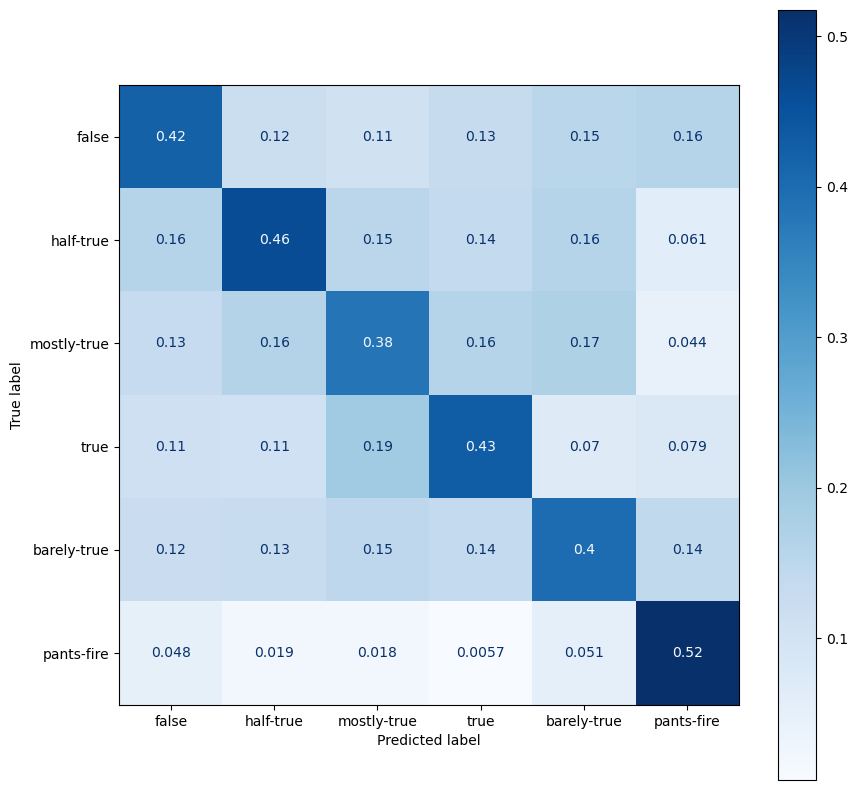

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

cm = confusion_matrix(y_test, pred_test, labels= TRAIN['label'].unique(), normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=TRAIN['label'].unique())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(cmap = 'Blues', ax=ax);

In [20]:
import joblib
joblib.dump(FzXGBoost_pipeline, 'XGBoost.pkl')

['XGBoost.pkl']